# Importo Librerias

Nota: Para probar el código de manera eficiente sugiero ignorar "Loop principal para Descarga y Cálculo del NDVI" y continuar en "Analisis Exploratorio", sino se descargará y calculara el NDVI que es lo que más demoró. Además, no descomentar las dos casillas comentadas ya que la data del análisis exploratorio ya se encuentra escrita en la carpeta.

In [ ]:
from shapely.geometry import Point, Polygon
from sentinelhub import SHConfig
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox
from pandas.io.json import json_normalize
from sentinelhub import CustomUrlParam
from json import loads
import seaborn as sns
import sentinelhub.io_utils as sio
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import datetime
import geojsonio
import os, sys
import warnings

In [ ]:
#Settings
%matplotlib notebook
np.seterr(divide='ignore', invalid='ignore')
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings('ignore')

# Sentinel Hub Instance

In [ ]:
instance_id = '304cf0b2-953d-4990-a354-d9f858653ba2'
config = SHConfig()
config.instance_id = instance_id

# Importo y Manipulo data de Lotes y Fechas

In [ ]:
#Date data
dates_data = pd.read_excel(r'C:\Users\Ash-n\Desktop\Space-Ag\challenge\SentinelHubImage-available_dates.xlsx')
dates = list(dates_data['_date'])

In [ ]:
#Lote Data
lotes_data = gpd.read_file(r'C:\Users\Ash-n\Desktop\Space-Ag\challenge\farm_map.json')
lotes_values = pd.DataFrame.from_records(lotes_data.loc[:,'values'].map(lambda x: loads(x)[0]))
lotes_unit = pd.DataFrame.from_records(lotes_data.loc[:,'unit'])
lotes = pd.concat([lotes_values.reset_index(drop=True),lotes_unit.reset_index(drop=True)], axis=1)
lotes['geometry'] = list(lotes_data['geometry'].map(lambda x: list(x.exterior.bounds)))
lotes['geometry'] = lotes_data['geometry']

# Loop principal para Descarga y Cálculo del NDVI

A continuación está el código con que descargo las bandas B04 y B08 (Red y NIR) y calculo el NDVI para toda la data. También guardo en una carpeta con la fecha e id del lote la data (NDVI, Red y NIR). Se puede mejorarel código para hacerlo más leíble pero no le ví mucho sentido hacerlo para este desafío.

In [ ]:
#DICT FOR DATA RESULTS
data_results = {'id':[], 'date':[],'ndvi_avg':[]}

#LOOP ON LOTE AND DATE
for index,lote in lotes.iterrows():
    lote_bbox = BBox(bbox=lote['geometry'],crs=CRS.WGS84)
    for date in dates:
        
        #DATE-LOTE FOLDER FOR DATA OUTPUT
        data_folder = 'output_data/'
        data_folder = data_folder + str(date) + '_' + str(lote['id'])
        
        #REQUEST RED BAND
        RED_REQUEST_L1C = WmsRequest(
            data_folder=data_folder,
            layer='RED-FOR-NDVI',
            bbox=lote_bbox,
            time=date,
            width=512,
            height=856,
            image_format=MimeType.TIFF_d32f,
            custom_url_params={
                CustomUrlParam.GEOMETRY:lote['geometry']
            },
            config=config
        )
        
        RED_L1C = np.array(RED_REQUEST_L1C.get_data(save_data=True))

        #REQUEST NIR BAND
        NIR_REQUEST_L1C = WmsRequest(
            data_folder=data_folder,
            layer='NIR-FOR-NDVI',
            bbox=lote_bbox,
            time=date,
            width=512,
            height=856,
            image_format=MimeType.TIFF_d32f,
            custom_url_params={
                CustomUrlParam.GEOMETRY:lote['geometry']
            },
            config=config
        )
        
        NIR_L1C = np.array(NIR_REQUEST_L1C.get_data(save_data=True))
        
        #CALCULATE NDVI and NDVI AVERAGE
        NDVI_L1C = np.divide(np.subtract(NIR_L1C,RED_L1C),np.add(NIR_L1C,RED_L1C))
        ndvi_average = np.nanmean(NDVI_L1C)
        
        #APPEND TO RESULTS
        data_results['id'].append(lote['id'])
        data_results['ndvi_avg'].append(ndvi_average)
        data_results['date'].append(date)
        
        #SAVE NDVI AS PNG in date-lote folder
        NDVI_L1C = np.nan_to_num(NDVI_L1C,nan=0)
        plt.imsave(data_folder+'/NDVI_'+str(date)+'.png', NDVI_L1C[-1])

#FINAL RESULTS AS DATAFRAME
data_results = pd.DataFrame(data_results)

# Análisis Exploratorio

Comienzo juntando la data de NDVI promedio con data de lotes generado anteriormente. Además escribo y leo la información para respaldarla.

In [ ]:
#lotes_with_ndvi = data_results.merge(lotes,on='id')

In [ ]:
#lotes_with_ndvi.to_csv('output_lotes_with_ndvi.csv',index=False)

In [8]:
lotes_with_ndvi = pd.read_csv('output_lotes_with_ndvi.csv')

# Calidad de la Data

Hay data para todos los días pero, al parecer hay imágenes con problemas donde el NDVI promedio es mayor a 1. Aproximádamente el 10% de los datos tienen valores de NDVI claramente afectados. Tienden a ser el mismo día para varios lotes. Lo más probable es que sean nubes que no se pudieron corregir suficientemente bien en la data de origen.

In [9]:
lotes_with_ndvi[lotes_with_ndvi['ndvi_avg'] > 1].sort_values(by=['date'])

,id,date,ndvi_avg,value,variety,measurement_unit,date_stamp,metadata,time_stamp,state,metadata.1,full_name,name,geometry
2935,90249,2016-09-13,1.998850,755.404573,{},Kg/Ha,2019-09-19,NaN,NaN,"{'area': 6.302737, 'year_of_planting': ['2019'...","[{'level_name': 'empresa', 'name': 'agricola c...",lote AGRICOLA CHAPI.DON ERNESTO.PAL-6.32,AGRICOLA CHAPI.DON ERNESTO.PAL-6.32,POLYGON ((-75.64898805011781 -14.1988135082976...
2134,90236,2016-09-13,2.020524,537.120263,{},Kg/Ha,2019-09-19,NaN,NaN,"{'area': 6.237954, 'year_of_planting': ['2019'...","[{'level_name': 'empresa', 'name': 'agricola c...",lote AGRICOLA CHAPI.DON ERNESTO.PAL-6.13,AGRICOLA CHAPI.DON ERNESTO.PAL-6.13,POLYGON ((-75.64497315728985 -14.1932910492140...
2668,90242,2016-09-13,1.953284,746.876592,{},Kg/Ha,2019-09-19,NaN,NaN,"{'area': 6.423636, 'year_of_planting': ['2019'...","[{'level_name': 'empresa', 'name': 'agricola c...",lote AGRICOLA CHAPI.DON ERNESTO.PAL-6.24,AGRICOLA CHAPI.DON ERNESTO.PAL-6.24,POLYGON ((-75.64430202199843 -14.1951328024683...
2579,90241,2016-09-13,2.095380,920.454738,{},Kg/Ha,2019-09-19,NaN,NaN,"{'area': 6.448333, 'year_of_planting': ['2019'...","[{'level_name': 'empresa', 'name': 'agricola c...",lote AGRICOLA CHAPI.DON ERNESTO.PAL-6.21,AGRICOLA CHAPI.DON ERNESTO.PAL-6.21,POLYGON ((-75.64968970670726 -14.1970429501923...
2846,90244,2016-09-13,1.992948,1151.521331,{},Kg/Ha,2019-09-19,NaN,NaN,"{'area': 6.329574, 'year_of_planting': ['2019'...","[{'level_name': 'empresa', 'name': 'agricola c...",lote AGRICOLA CHAPI.DON ERNESTO.PAL-6.26,AGRICOLA CHAPI.DON ERNESTO.PAL-6.26,POLYGON ((-75.64964409685477 -14.1970270320072...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,90244,2019-11-17,1.563451,1151.521331,{},Kg/Ha,2019-09-19,NaN,NaN,"{'area': 6.329574, 'year_of_planting': ['2019'...","[{'level_name': 'empresa', 'name': 'agricola c...",lote AGRICOLA CHAPI.DON ERNESTO.PAL-6.26,AGRICOLA CHAPI.DON ERNESTO.PAL-6.26,POLYGON ((-75.64964409685477 -14.1970270320072...
2056,90236,2019-11-17,1.352261,537.120263,{},Kg/Ha,2019-09-19,NaN,NaN,"{'area': 6.237954, 'year_of_planting': ['2019'...","[{'level_name': 'empresa', 'name': 'agricola c...",lote AGRICOLA CHAPI.DON ERNESTO.PAL-6.13,AGRICOLA CHAPI.DON ERNESTO.PAL-6.13,POLYGON ((-75.64497315728985 -14.1932910492140...
2323,90239,2019-11-17,1.086243,767.279929,{},Kg/Ha,2019-09-19,NaN,NaN,"{'area': 6.3347, 'year_of_planting': ['2019'],...","[{'level_name': 'empresa', 'name': 'agricola c...",lote AGRICOLA CHAPI.DON ERNESTO.PAL-6.18,AGRICOLA CHAPI.DON ERNESTO.PAL-6.18,POLYGON ((-75.64166749773169 -14.1942131642688...
2590,90242,2019-11-17,1.138529,746.876592,{},Kg/Ha,2019-09-19,NaN,NaN,"{'area': 6.423636, 'year_of_planting': ['2019'...","[{'level_name': 'empresa', 'name': 'agricola c...",lote AGRICOLA CHAPI.DON ERNESTO.PAL-6.24,AGRICOLA CHAPI.DON ERNESTO.PAL-6.24,POLYGON ((-75.64430202199843 -14.1951328024683...


# Transformaciones para análisis exploratorio

Por lo anterior, no consideraré los valores claramente alterados. A continuación selecciono solo NDVIs menores a 1 y transformo nombres de columnas y formatos a fecha según sea útil.

In [12]:
lotes_ndvi = lotes_with_ndvi[lotes_with_ndvi['ndvi_avg'] < 1].sort_values(by=['date'])
lotes_ndvi = lotes_ndvi.rename(columns={'date':'ndvi_date','date_stamp':'kg_ha_measurement_date','value':'kg_ha_value'})
lotes_ndvi['kg_ha_measurement_date'] =  pd.to_datetime(lotes_ndvi.loc[:,'kg_ha_measurement_date'], format='%Y-%m-%d')
lotes_ndvi['ndvi_date'] =  pd.to_datetime(lotes_ndvi.loc[:,'ndvi_date'], format='%Y-%m-%d')

# Análisis

En este primer análisis tomo los datos de NDVI medidos después de la medición de Kg/Ha para ver si realmente exite una relación entre ambas variables. No es una muy buena comparación porque hay mediciones de Kg/Ha muy lejanas (y muchos días antes) de la medición de NDVI. Al menos con estos datos se observa una relación bastante fuerte 54% aproximadamente. A continuación tomo otro enfoque para calcular la correlación.

<IPython.core.display.Javascript object>


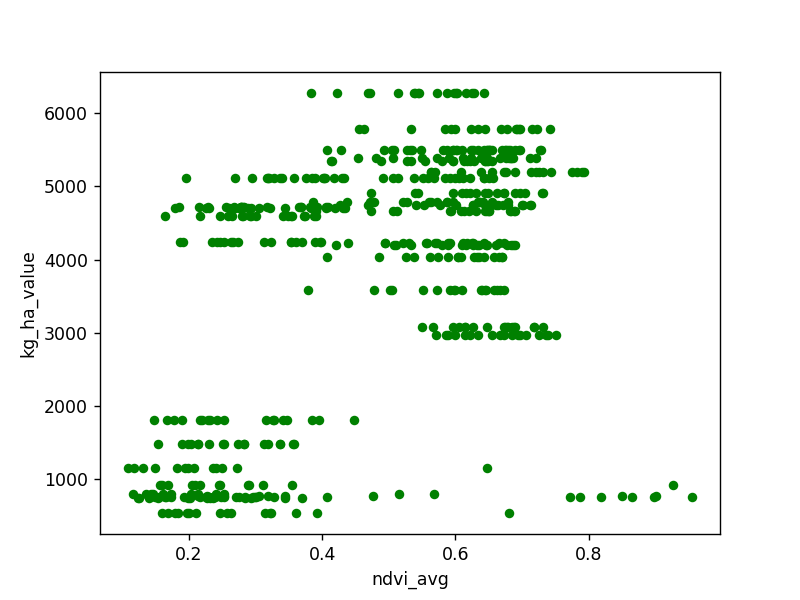

,ndvi_avg,kg_ha_value
ndvi_avg,1.000000,0.535806
kg_ha_value,0.535806,1.000000


In [14]:
exploratory_data = lotes_ndvi[['ndvi_avg',
                               'kg_ha_value',
                               'ndvi_date',
                               'kg_ha_measurement_date']][(lotes_ndvi['ndvi_date']) > (lotes_ndvi['kg_ha_measurement_date'])]

exploratory_data.plot.scatter('ndvi_avg','kg_ha_value',c='green')
exploratory_data.corr()

Ahora, para tener un grupo más consistente con las mediciones entre los Kg/Ha y el NDVI, solo considero mediciones de NDVI que hayan sido en +-15 días de la medición de Kg/Ha. En esta medición encuentro que la correlación anterior podría estar sobrestimada. Ahora la correlación es de 25%. Finalmente podría concluir que realmente existe una relación positiva entre el NDVI y los Kg/Ha como afirman los agricultores. A continuación muestro dos pequeños análisis más.

<IPython.core.display.Javascript object>


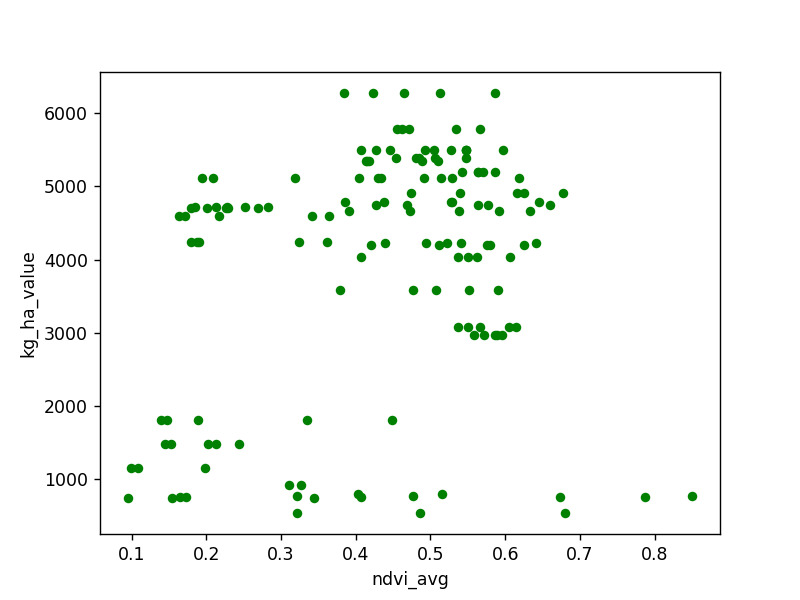

,ndvi_avg,kg_ha_value
ndvi_avg,1.000000,0.253079
kg_ha_value,0.253079,1.000000


In [23]:
exploratory_data = lotes_ndvi[['ndvi_avg',
                               'kg_ha_value',
                               'ndvi_date',
                               'kg_ha_measurement_date']]
exploratory_data['dd_from_ndvi_to_kg_measurement'] = (exploratory_data.loc[:,'ndvi_date'] - exploratory_data.loc[:,'kg_ha_measurement_date']).dt.days
exploratory_data = exploratory_data[exploratory_data.loc[:,'dd_from_ndvi_to_kg_measurement'].between(-15,15)]
exploratory_data = exploratory_data[['ndvi_avg','kg_ha_value']]
exploratory_data.plot.scatter('ndvi_avg','kg_ha_value',c='green')
exploratory_data.corr()

Primero, se entiende que el producto son paltas Hass Fuerte Zutano Según la data entregada. Dado esto, si existe una relación con el NDVI este debería tender a subir en los periodos cercanos a la cosecha que según entiendo entre julio y octubre. Se puede observar en el gráfico que tienden a ser esos los períodos con mayor NDVI. Mientras que principio de año el NDVI tiende a ser más bajo.

<IPython.core.display.Javascript object>


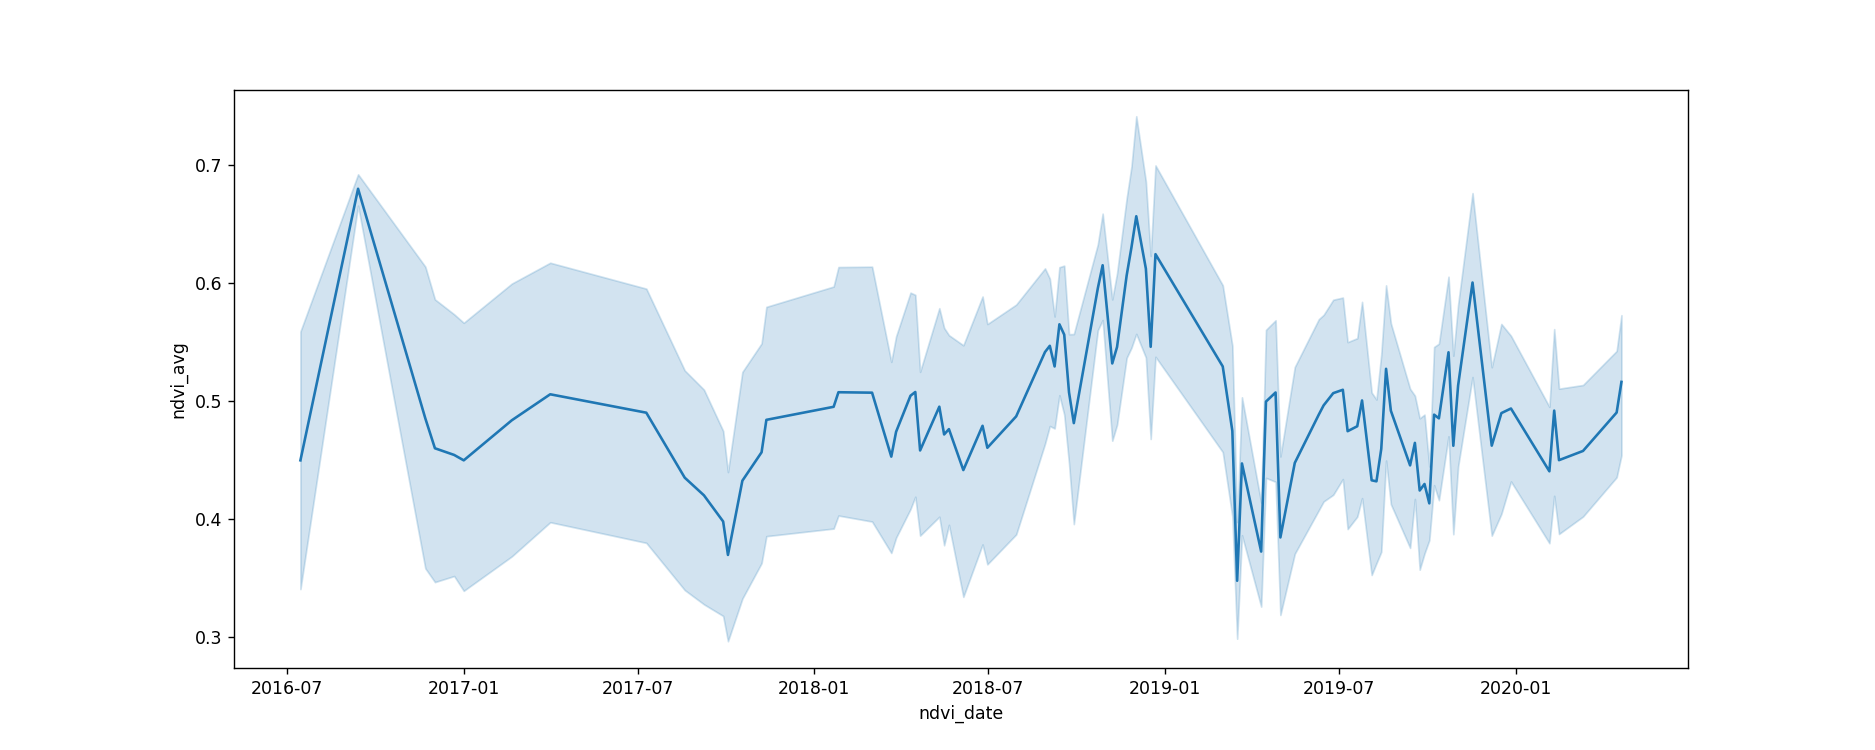

In [24]:
exploratory_data = lotes_ndvi.set_index(lotes_ndvi.ndvi_date)
fig, ax = plt.subplots(figsize = (15,6))
fig = sns.lineplot(x = "ndvi_date", y = "ndvi_avg", data = exploratory_data, ax=ax)

Segundo, sin saber si se tiene claro cuales son los mejores lotes de los 33 analizados. Se gráfica a continuación el NDVI de todos los lotes en el tiempo. Si bien este no es un gráfico para presentar, si se puede observar que existen a priori tres grupos. Los ids más altos han tendido a tener un NDVI más alto que los lotes con ids más bajos. Aunque pareciera que en 2019 hubo una equiparación en el NDVI de todos los lotes. Se podría ahondar en que lotes son y quizás crear un modelo de clustering para poder caracterizar mejor estos lotes, si es que a los agricultores les parece información relevante y que ellos no poseen.

<IPython.core.display.Javascript object>


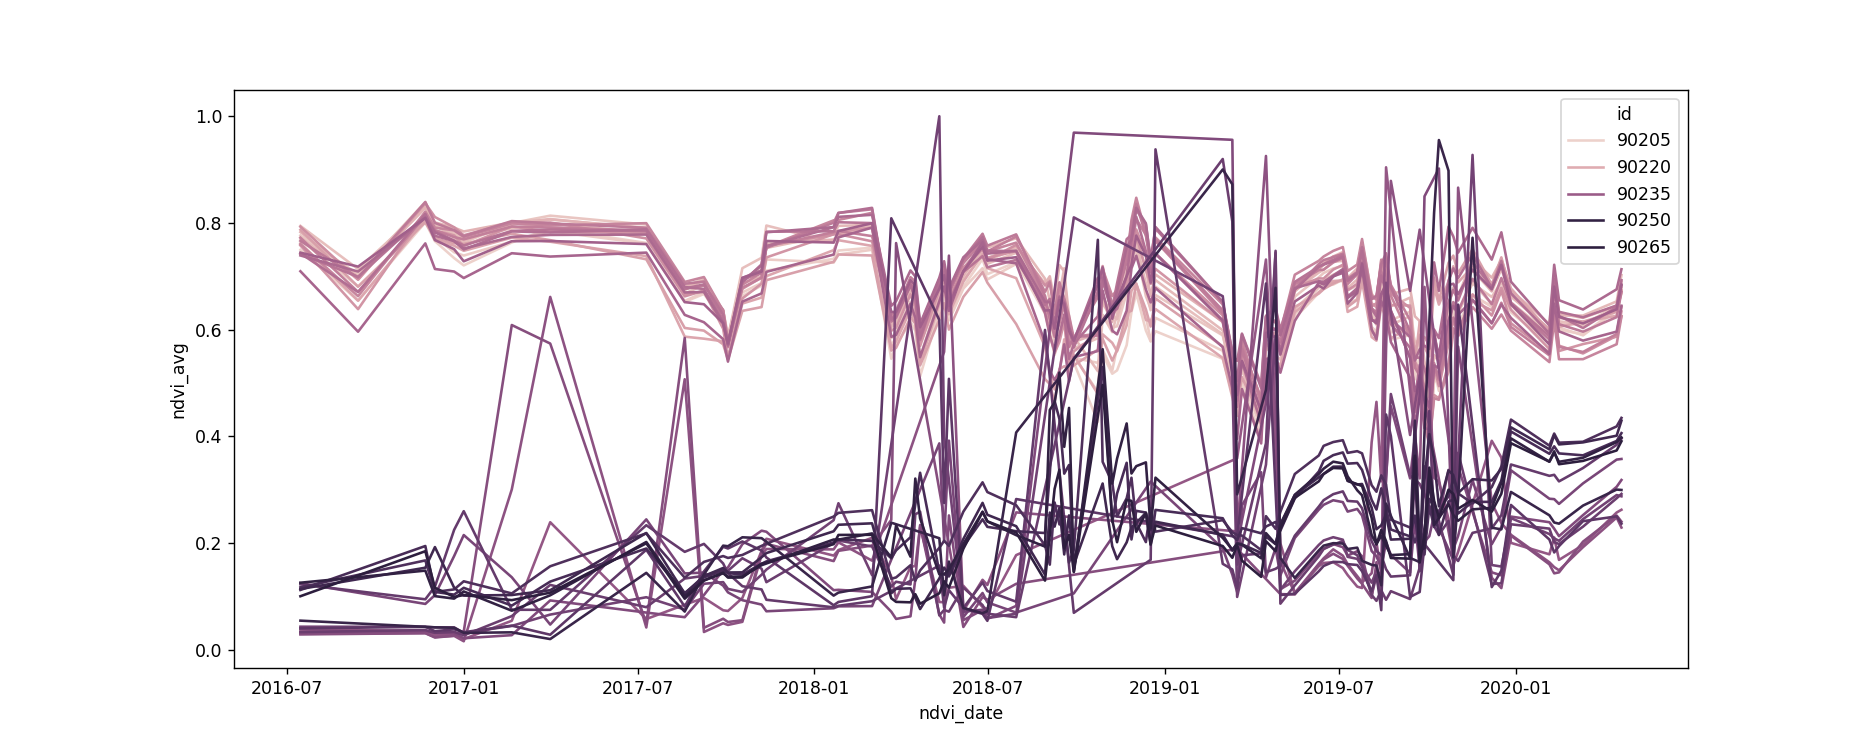

In [25]:
exploratory_data = lotes_ndvi.set_index(lotes_ndvi.ndvi_date)
fig, ax = plt.subplots(figsize = (15,6))
fig = sns.lineplot(x = "ndvi_date", y = "ndvi_avg", data = exploratory_data, ax=ax, hue="id")

Muchas gracias por leer, hay varias cosas mejorables en este análisis pero no lo considere tan importante para este caso, algunos ejemplos: el Loop es bastante ineficiente, entiendo que hay otras formas de hacer el request a sentinel hub que podrían ser mucho mejores en cuanto a uso de cuota de requests y a tiempo de ejecución del código, tampoco es eficiente la forma de escribir los NDVI al disco. Los gráficos no están en condiciones para ser presentados a alguien que no entienda todo lo realizado en el análisis y se podrían dejar más ordenados. 